# Regression using a Neural Network (Keras)
The data is in 'housing.csv'. <br>
Each row in the table is a data point:  the features of an area in California <br>
Clearly, the `median_house_value` is correlated with some other features, e.g., `median_income` and location <br>
Thus, we can estimate `median_house_value` = regression_model(`median_income`, `longitude`, `latitude`, ...) <br>
The taks is to build an MLP regressor to predict `median_house_value` using the other features

In [1]:
import tensorflow.keras as keras
import sys
sys.modules['keras'] = keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd

In [2]:
housing = pd.read_csv("housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.shape

(20640, 10)

### Data pre-processing: remove NaN

In [4]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
# there are 207 NaN in the column 'total_bedrooms', remove them
# check housing again using housing.isnull().sum()
housing['total_bedrooms'].fillna((housing['total_bedrooms'].mean()), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### Data pre-processing: Convert categorical data to numerical data - "ocean_proximity"

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
#We can use one-hot encoding method by calling pd.get_dummies
categorical_columns=['ocean_proximity'] # must be a list
housing = pd.get_dummies(housing, columns=categorical_columns)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


### Visualize the data

Text(0.5, 1.0, 'median_income')

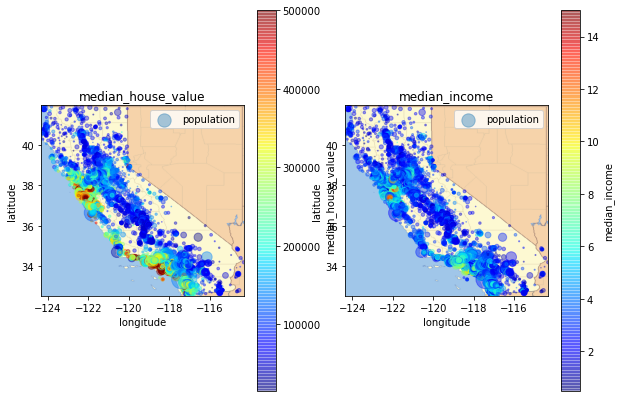

In [8]:
from skimage.io import imread
california_img = imread('california.png')
x1 = min(housing["longitude"].values)
x2 = max(housing["longitude"].values)
y1 = min(housing["latitude"].values)
y2 = max(housing["latitude"].values)
#---------------------------------------------
# the parameter c refers to color
# thus, median_house_value is color-coded in the left plot
fig, ax =plt.subplots(1,2)
housing.plot(ax=ax[0], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
#---------------------------------------------
# the parameter c refers to color
# thus, median_income is color-coded in the right plot
ax[0].imshow(california_img,extent=[x1,x2,y1,y2])
ax[0].set_title('median_house_value')
housing.plot(ax=ax[1], kind="scatter", x="longitude", y="latitude",
             s=housing['population']/100, label="population",
             c="median_income", cmap=plt.get_cmap("jet"),
             colorbar=True, alpha=0.4, figsize=(10,7))
ax[1].imshow(california_img,extent=[x1,x2,y1,y2])
ax[1].set_title('median_income')

### Prepare the Training and Testing Datasets

In [9]:
X=housing.drop(['median_house_value'], axis=1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,0,0,0,1,0


In [10]:
Y=housing['median_house_value']
Y.head()

0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64

In [11]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X_columns=X.columns #store the column names
X=X.values.astype('float32')
Y=Y.values.astype('float32')

### trainnig, validation, testing split

In [12]:
#trainnig, validation, testing split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (14860, 13) (14860,)
validation: (1652, 13) (1652,)
test: (4128, 13) (4128,)


In [13]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scalerX=MinMaxScaler()
scalerX.fit(X_train) # think about why fit to X_train, not X ?
X_train=scalerX.transform(X_train)
X_val=scalerX.transform(X_val)
X_test=scalerX.transform(X_test)

In [14]:
X_train[0]

array([0.5786848 , 0.38044596, 0.19607843, 0.12570114, 0.13671634,
       0.00983827, 0.02795593, 0.11055019, 0.        , 1.        ,
       0.        , 0.        , 0.        ], dtype=float32)

In [15]:
#normalize the output to facilitate convergence
Y_train_max=Y_train.max()
Y_train/=Y_train_max
Y_val/=Y_train_max
Y_test/=Y_train_max

### use LinearRegression as the baseline model

In [16]:
#step1:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)

In [17]:
#step2:
linear_model.fit(X_train, Y_train)

LinearRegression()

In [18]:
linear_model.coef_

array([-0.5266751 , -0.4705757 ,  0.11070077, -0.3135679 ,  0.87252647,
       -2.802685  ,  1.0090173 ,  1.1304909 , -0.04724935, -0.12497991,
        0.26538444, -0.05612908, -0.03702427], dtype=float32)

In [19]:
linear_model.intercept_

0.5496527

Evaluate model on testing set
MSE= 0.018863903
MAE= 0.09931181
MAPE= 0.28951436


Text(0, 0.5, 'Y_test_pred')

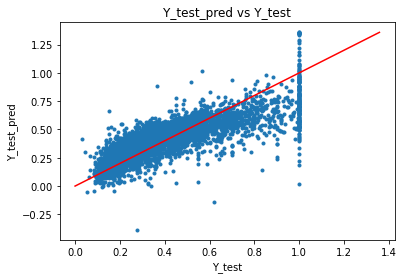

In [20]:
#step3:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)
print('Evaluate model on testing set')
MSE = np.mean((Y_test - Y_test_pred)**2)
MAE = np.mean(np.abs(Y_test - Y_test_pred))
MAPE =  np.mean(np.abs(Y_test - Y_test_pred)/Y_test)
print('MSE=', MSE)
print('MAE=', MAE)
print('MAPE=', MAPE)
#step6: 
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.set_title('Y_test_pred vs Y_test')
ax.plot(Y_test, Y_test_pred, '.')
ymax=np.max([Y_test.max(), Y_test_pred.max()])
ax.plot(np.linspace(0,ymax, 3), np.linspace(0, ymax, 3), '-r')
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')

## Your work begins here
see NN_nonlinear_regression_Keras.ipynb

#### define the model

In [21]:
model = Sequential()
model.add(Dense(units=16, activation='softplus', input_shape=(13,)))
model.add(Dense(units=16, activation='softplus'))
model.add(Dense(units=1, activation='linear'))
model.compile(loss='mse', optimizer=SGD(lr=0.01, momentum=0.9))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


#### Now, let's train the model for 100 epochs

In [22]:
loss_train_list=[]
loss_val_list=[]

In [23]:
for epoch in range(0, 100):
    #set epochs=1
    print('epoch', epoch)
    history=model.fit(X_train, Y_train, batch_size=64, epochs=1, validation_data=(X_val, Y_val))
    loss_train_list.extend(history.history['loss'])
    loss_val_list.extend(history.history['val_loss'])

epoch 0
233/233 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0348
epoch 1
233/233 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.0279
epoch 2
233/233 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0245
epoch 3
233/233 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0241
epoch 4
233/233 [==============================] - 0s 1ms/step - loss: 0.0224 - val_loss: 0.0245
epoch 5
233/233 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0255
epoch 6
233/233 [==============================] - 0s 1ms/step - loss: 0.0219 - val_loss: 0.0252
epoch 7
233/233 [==============================] - 0s 1ms/step - loss: 0.0219 - val_loss: 0.0234
epoch 8
233/233 [==============================] - 0s 852us/step - loss: 0.0216 - val_loss: 0.0227
epoch 9
233/233 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0230
epoch 10
233/233 [==========

233/233 [==============================] - 0s 932us/step - loss: 0.0187 - val_loss: 0.0233
epoch 83
233/233 [==============================] - 0s 972us/step - loss: 0.0189 - val_loss: 0.0198
epoch 84
233/233 [==============================] - 0s 770us/step - loss: 0.0188 - val_loss: 0.0199
epoch 85
233/233 [==============================] - 0s 850us/step - loss: 0.0188 - val_loss: 0.0211
epoch 86
233/233 [==============================] - 0s 1ms/step - loss: 0.0187 - val_loss: 0.0213
epoch 87
233/233 [==============================] - 0s 842us/step - loss: 0.0187 - val_loss: 0.0201
epoch 88
233/233 [==============================] - 0s 1ms/step - loss: 0.0185 - val_loss: 0.0200
epoch 89
233/233 [==============================] - 0s 1ms/step - loss: 0.0187 - val_loss: 0.0200
epoch 90
233/233 [==============================] - 0s 1ms/step - loss: 0.0187 - val_loss: 0.0205
epoch 91
233/233 [==============================] - 0s 951us/step - loss: 0.0187 - val_loss: 0.0203
epoch 92
233/233 

plot the loss vs epoch curve

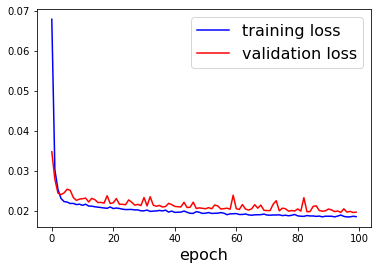

In [24]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

after training, we evaluate the model on the test dataset

In [25]:
# get the loss on test set
score = model.evaluate(X_test, Y_test, batch_size=64, verbose=0)
print('Test loss:', score)

Test loss: 0.018331052735447884


In [26]:
#get Yp_test by using model.predict
Yp_test=model.predict(X_test, batch_size=64)

In [27]:
type(Yp_test)

numpy.ndarray

In [28]:
Yp_test.shape

(4128, 1)

In [29]:
Yp_test=Yp_test.squeeze()

In [30]:
Yp_test.shape

(4128,)

In [31]:
Y_test.shape

(4128,)

In [32]:
# compute MSE, MAE and MAPE on the test set
MSE = np.mean((Y_train - Y_train_pred)**2)
MAE = np.mean(np.abs(Y_train - Y_train_pred))
MAPE =  np.mean(np.abs(Y_train - Y_train_pred)/Y_train)
#
print("Evaluate model on testing set")
print("MSE=",MSE)
print("MAE=",MAE)
print("MAPE=",MAPE)

Evaluate model on testing set
MSE= 0.018703457
MAE= 0.099351116
MAPE= 0.28700456


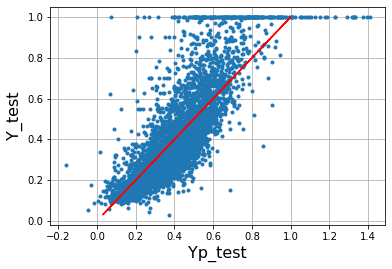

In [33]:
# plot Yp_test vs Y_test
# the red line is the 45-degree line
fig, ax = plt.subplots()
ax.plot(Yp_test, Y_test, '.')
ax.plot(Y_test, Y_test, 'r-')
ax.set_xlabel('Yp_test', fontsize=16)
ax.set_ylabel('Y_test', fontsize=16)
ax.grid(True)

### change the structure of the MLP model and see if it can do better than XGBoost

In [ ]:
#define a new model
#train, validate and test the model